## Dependencies

In [2]:
from tqdm import tqdm
import statistics

import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import SNAPDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.utils import negative_sampling, to_networkx

torch.manual_seed(0)

%matplotlib notebook

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

orig_transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
])

transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

orig_dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=orig_transform)
dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=transform)

data = orig_dataset[0]
train_data, val_data, test_data = dataset[0]

In [4]:
print(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[2432], edge_label_index=[2, 2432])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[284], edge_label_index=[2, 284])
Data(x=[347, 1406], edge_index=[2, 5148], circle=[325], circle_batch=[325], edge_label=[570], edge_label_index=[2, 570])


## Prediction

In [5]:
from torch import nn
import torch.nn.functional as F


class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.hstack((-out, out)).T


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # TODO: look into SAGEConv, GATConv, GINConv, comparison between
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.W1 = nn.Linear(out_channels * 2, out_channels)
        self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        z1 = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        out1 = self.W2(F.relu(self.W1(z1)).squeeze())
        
        z2 = torch.cat((z[edge_label_index[1]], z[edge_label_index[0]]), dim=1)
        out2 = self.W2(F.relu(self.W1(z2)).squeeze())
        
        return (out1 + out2) / 2
    
    def forward(self, x, edge_index, edge_label_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_label_index)
        return torch.hstack((-out, out)).T

simple_model = SimpleNet(dataset.num_features, 128, 32).to(device)
simple_optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=3e-3)
    
model = Net(dataset.num_features, 128, 32).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: These methods simultaneously use node feature and graph structure properties.
#       Is it possible to train models that look at each aspect separately
#       Can look at only node features by just passing original layer to MLP
#       Unsure if can look at only graph by passing random vector into GCNConv
#       Should also read up on Node2Vec and other methods of generating node embeddings (talk to Rex)

In [6]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, 
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1], 
        method='sparse'
    )
    
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    a, b = data.edge_label.cpu().numpy(), out.cpu().numpy()
    c = (out > 0.5).float().cpu().numpy()
    return roc_auc_score(a, b), accuracy_score(a, c)

In [7]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(simple_model, simple_optimizer, train_data)
    val_auc, val_acc = test(simple_model, val_data)
    test_auc, test_acc = test(simple_model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

simple_z = simple_model.encode(test_data.x, test_data.edge_index)
simple_final_edge_index = simple_model.decode(simple_z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4885, Val: 0.9359 0.7641, Test: 0.9087 0.7614
Epoch: 100, Loss: 0.4630, Val: 0.9423 0.7817, Test: 0.9120 0.7667
Epoch: 150, Loss: 0.4521, Val: 0.9445 0.7676, Test: 0.9197 0.7684
Epoch: 200, Loss: 0.4409, Val: 0.9262 0.7746, Test: 0.8996 0.7684
Epoch: 250, Loss: 0.4487, Val: 0.9256 0.7817, Test: 0.8930 0.7649
Epoch: 300, Loss: 0.4271, Val: 0.9228 0.8063, Test: 0.8958 0.7737
Epoch: 350, Loss: 0.4347, Val: 0.9225 0.7817, Test: 0.8989 0.7684
Epoch: 400, Loss: 0.4410, Val: 0.9183 0.7746, Test: 0.8950 0.7614
Epoch: 450, Loss: 0.4302, Val: 0.9120 0.7923, Test: 0.8882 0.7754
Epoch: 500, Loss: 0.4158, Val: 0.9089 0.7852, Test: 0.8852 0.7789
Epoch: 550, Loss: 0.4073, Val: 0.9197 0.8028, Test: 0.8901 0.7912
Epoch: 600, Loss: 0.4140, Val: 0.9174 0.8169, Test: 0.8924 0.7877
Epoch: 650, Loss: 0.4100, Val: 0.9064 0.8063, Test: 0.8828 0.8000
Epoch: 700, Loss: 0.4081, Val: 0.9083 0.8169, Test: 0.8839 0.7982
Epoch: 750, Loss: 0.4040, Val: 0.9131 0.8099, Test: 0.8892 0.7912
Epoch: 800

In [8]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(model, optimizer, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode(z, test_data.edge_label_index)

Epoch: 050, Loss: 0.3897, Val: 0.9260 0.8204, Test: 0.9115 0.8404
Epoch: 100, Loss: 0.3101, Val: 0.9458 0.8803, Test: 0.9511 0.8877
Epoch: 150, Loss: 0.2844, Val: 0.9550 0.8662, Test: 0.9538 0.8982
Epoch: 200, Loss: 0.2688, Val: 0.9599 0.8838, Test: 0.9542 0.8965
Epoch: 250, Loss: 0.2705, Val: 0.9622 0.8908, Test: 0.9534 0.8912
Epoch: 300, Loss: 0.2650, Val: 0.9639 0.8979, Test: 0.9533 0.9000
Epoch: 350, Loss: 0.2626, Val: 0.9665 0.8908, Test: 0.9533 0.8965
Epoch: 400, Loss: 0.2460, Val: 0.9689 0.9085, Test: 0.9544 0.9070
Epoch: 450, Loss: 0.2432, Val: 0.9704 0.9155, Test: 0.9545 0.9070
Epoch: 500, Loss: 0.2391, Val: 0.9704 0.9085, Test: 0.9556 0.9053
Epoch: 550, Loss: 0.2361, Val: 0.9720 0.9225, Test: 0.9560 0.9070
Epoch: 600, Loss: 0.2325, Val: 0.9710 0.9014, Test: 0.9564 0.9018
Epoch: 650, Loss: 0.2371, Val: 0.9701 0.9085, Test: 0.9572 0.8965
Epoch: 700, Loss: 0.2445, Val: 0.9697 0.9014, Test: 0.9576 0.9035
Epoch: 750, Loss: 0.2363, Val: 0.9711 0.9049, Test: 0.9578 0.9053
Epoch: 800

In [9]:
(test_data.edge_label == (torch.sigmoid(simple_final_edge_index.squeeze()) > 0.7)).sum() / test_data.edge_label.shape[0]

tensor(0.8596)

In [10]:
(test_data.edge_label == (torch.sigmoid(final_edge_index.squeeze()) > 0.5)).sum() / test_data.edge_label.shape[0]

tensor(0.9053)

In [11]:
simple_model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[-0.3379, -1.0981,  0.3084,  ...,  1.4550, -0.4870,  0.1822],
        [ 0.3379,  1.0981, -0.3084,  ..., -1.4550,  0.4870, -0.1822]],
       grad_fn=<PermuteBackward0>)

In [12]:
model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ -8.1702,  -1.1841,  -1.7375,  ...,   8.3011,  10.5043,   0.3920],
        [  8.1702,   1.1841,   1.7375,  ...,  -8.3011, -10.5043,  -0.3920]],
       grad_fn=<PermuteBackward0>)

## Exploration

In [13]:
test_data.edge_label_index[:, 12]

tensor([ 24, 187])

In [14]:
node_1 = 24
node_2 = 187

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {256, 129, 2, 269, 270, 271, 275, 147, 276, 20, 279, 25, 282, 157, 30, 289, 290, 38, 39, 168, 169, 296, 175, 50, 55, 184, 185, 64, 321, 66, 322, 324, 68, 198, 71, 199, 72, 330, 75, 331, 335, 82, 83, 87, 346, 220, 93, 223, 97, 230, 231, 103, 102, 104, 235, 236, 238, 112, 245, 121}
Node 2 Neighbors: {257, 2, 132, 8, 12, 141, 270, 271, 273, 276, 20, 279, 25, 155, 284, 29, 289, 290, 164, 296, 169, 303, 175, 55, 184, 185, 314, 321, 322, 66, 199, 74, 333, 78, 207, 84, 341, 222, 103, 238, 112, 118, 121, 251}
Overlapping Neighbors: {2, 270, 271, 276, 20, 279, 25, 289, 290, 296, 169, 175, 55, 184, 185, 321, 322, 66, 199, 103, 238, 112, 121}


<IPython.core.display.Javascript object>


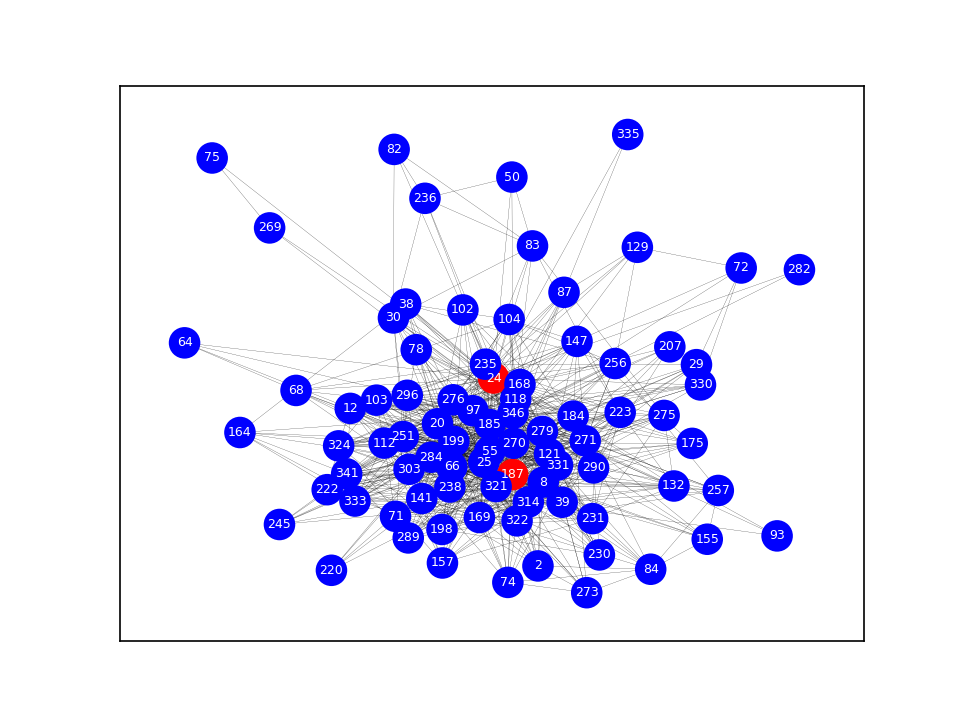

In [15]:
nodes = [node_1, node_2] + list(node_1_neighbors.union(node_2_neighbors))
colors = ["red", "red"] + ["blue" for _ in nodes[2:]]

fig, ax = plt.subplots()
g = to_networkx(test_data, to_undirected=True)
h = g.subgraph(nodes)
nx.draw_networkx(h, node_size=200, nodelist=nodes, node_color=colors, width=0.1, font_color="white", font_size=6)
plt.show()

In [16]:
old_z = model.encode(test_data.x, test_data.edge_index)
old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
print(old_pred)

tensor([5.6173], grad_fn=<DivBackward0>)


In [17]:
for neighbor in node_1_neighbors.union(node_2_neighbors):
    temp_x = test_data.x.clone()
    temp_x[neighbor] = 0
    new_z = model.encode(temp_x, test_data.edge_index)
    new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
    print(neighbor, "\t", round(new_pred.item(), 5))

256 	 5.57546
257 	 5.51899
2 	 5.56083
8 	 5.5928
12 	 5.54455
269 	 5.97394
270 	 5.48473
271 	 5.47972
273 	 5.58281
275 	 5.62191
276 	 5.60135
20 	 5.55657
279 	 5.6206
25 	 5.61744
282 	 5.58893
284 	 5.44487
29 	 5.62767
30 	 5.59647
289 	 5.57032
290 	 5.60247
38 	 5.61764
39 	 5.5123
296 	 5.66821
303 	 5.63152
50 	 5.64241
55 	 5.42925
314 	 5.66053
64 	 5.60347
321 	 5.62996
66 	 5.50936
322 	 5.44688
324 	 5.61203
68 	 5.61152
71 	 5.56377
72 	 5.54843
330 	 5.63793
75 	 5.78508
331 	 5.66892
74 	 5.61345
333 	 5.59437
335 	 5.75579
78 	 5.63209
82 	 5.64231
83 	 5.54372
84 	 5.64534
341 	 5.60268
87 	 5.68077
346 	 5.36574
93 	 5.61582
97 	 5.61022
102 	 5.62243
103 	 5.57625
104 	 5.6098
112 	 5.5683
118 	 5.60268
121 	 5.58929
129 	 5.6162
132 	 5.59596
141 	 5.58617
147 	 5.64202
155 	 5.42821
157 	 5.61007
164 	 5.60749
168 	 5.56249
169 	 5.55765
175 	 5.5666
184 	 5.60627
185 	 5.60531
198 	 5.54509
199 	 5.63855
207 	 5.66502
220 	 5.60099
222 	 5.59873
223 	 5.5814

In [18]:
# Start implementing GNNExplainer, PGExplainer, and SubgraphX architectures with 1-hop subgraph as parameters
# Think about separately learning node feature explanations

## GNNExplainer

In [19]:
from math import sqrt

from torch_geometric.nn import GNNExplainer
from torch_geometric.nn.models.explainer import clear_masks, set_masks
from torch_geometric.utils import k_hop_subgraph

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    coeffs = {
        'edge_size': 0.10,  # 0.005
        'edge_reduction': 'sum',  # sum
        'edge_ent': 1.0,  # 1.0
    }
    
    def _initialize_masks(self, x, edge_index, sub_edge_mask=None, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        self.node_feat_mask = torch.nn.Parameter(100 * torch.ones(1, F))
        
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        if sub_edge_mask is None:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)
        else:
            E_1, mask = sub_edge_mask.sum(), 100 * torch.ones(E)
            mask[sub_edge_mask] = torch.randn(E_1) * std
            self.edge_mask = torch.nn.Parameter(mask)  
    
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction]
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = (
            error_loss + 
            self.coeffs['edge_size'] * edge_size_loss + 
            self.coeffs['edge_ent'] * edge_ent_loss
        )
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    
    """
    # Alternative loss function that tries to simultaneously optimize constraints
    # From qualitative testing, seems to better satisfy both constraints
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction].clip(-6, 6)
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = - (1 - (error_loss + 6) / 12) * (1 - torch.mean(m)) + 0.1 * edge_ent_loss
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    """
    
    def subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        subset_1, edge_index_1, _, edge_mask_1 = k_hop_subgraph(
            node_idx_1, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        subset_2, edge_index_2, _, edge_mask_2 = k_hop_subgraph(
            node_idx_2, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        # Combines two node-centered subgraphs
        temp_node_idx = edge_index[0].new_full((num_nodes,), -1)  # full size
        edge_mask = edge_mask_1 | edge_mask_2
        edge_index = edge_index[:, edge_mask]  # filters out edges
        subset = torch.cat((subset_1, subset_2)).unique()
        temp_node_idx[subset] = torch.arange(subset.size(0), device=edge_index.device)
        edge_index = temp_node_idx[edge_index]  # maps edge_index to [0, n]
        x = x[subset]  # filters out nodes
        mapping = torch.tensor([
            (subset == node_idx_1).nonzero().item(), 
            (subset == node_idx_2).nonzero().item(),
        ])
        
        # Only optimizes the edges from neighbors to node_1/node_2, other direction not needed for prediction
        sub_edge_mask = (edge_index[1] == mapping[0]) |  (edge_index[1] == mapping[1])
        
        return x, edge_index, mapping, edge_mask, subset, sub_edge_mask
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        # Only operate on a k-hop subgraph around `node_idx_1` and `node_idx_2.
        x, edge_index, mapping, hard_edge_mask, subset, sub_edge_mask = \
            self.subgraph(node_idx_1, node_idx_2, x, edge_index)
        self.sub_edge_mask = sub_edge_mask
        edge_label_index=mapping.unsqueeze(1)
        
        # Get the initial prediction
        prediction = self.get_initial_prediction(x, edge_index, edge_label_index=edge_label_index)
        
        self._initialize_masks(x, edge_index, sub_edge_mask)
        self.to(x.device)

        set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
        optimizer = torch.optim.Adam([self.edge_mask], lr=self.lr)

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x=x, edge_index=edge_index, edge_label_index=edge_label_index)
            loss = self.get_loss(out, prediction, mapping).mean()
            loss.backward()
            optimizer.step()

        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        
        self._clear_masks()

        return edge_mask

In [20]:
x = test_data.x
edge_index = test_data.edge_index

node_idx_1 = node_1  # test_data.edge_label_index[0, 0].item()
node_idx_2 = node_2  # test_data.edge_label_index[1, 0].item()

print(node_idx_1, node_idx_2)

explainer = EdgeGNNExplainer(model, epochs=200, lr=0.1)
edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

print("Done!")

24 187
-0.21   	 51.6268   	 0.6925   	 5.6452   	
-0.314   	 51.578   	 0.6914   	 5.5352   	
-0.4176   	 51.5316   	 0.6878   	 5.4234   	
-0.52   	 51.4838   	 0.6818   	 5.3102   	
-0.6064   	 51.4384   	 0.6735   	 5.211   	
-0.6527   	 51.3944   	 0.6642   	 5.1509   	
-0.6908   	 51.3631   	 0.6538   	 5.0992   	
-0.7171   	 51.4391   	 0.644   	 5.0708   	
-0.7411   	 51.5458   	 0.6353   	 5.0488   	
-0.7766   	 51.6775   	 0.6272   	 5.0183   	
-0.8202   	 51.8251   	 0.6194   	 4.9817   	


C:\Users\Abhijit\AppData\Local\Temp\ipykernel_17184\81617139.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  return torch.hstack((-out, out)).T


-0.8696   	 51.9827   	 0.6118   	 4.9404   	
-0.9236   	 52.1465   	 0.6042   	 4.8953   	
-0.981   	 52.314   	 0.5966   	 4.847   	
-1.041   	 52.4829   	 0.5888   	 4.7961   	
-1.1031   	 52.6518   	 0.5807   	 4.7429   	
-1.1613   	 52.8192   	 0.5724   	 4.693   	
-1.2041   	 52.961   	 0.5631   	 4.6552   	
-1.2375   	 53.0798   	 0.5531   	 4.6235   	
-1.2688   	 53.1738   	 0.5421   	 4.5906   	
-1.2984   	 53.2464   	 0.5303   	 4.5566   	
-1.3262   	 53.3005   	 0.518   	 4.5218   	
-1.3524   	 53.3387   	 0.5052   	 4.4867   	
-1.3769   	 53.3634   	 0.4922   	 4.4516   	
-1.3999   	 53.3764   	 0.4789   	 4.4167   	
-1.4213   	 53.3796   	 0.4656   	 4.3823   	
-1.4412   	 53.3744   	 0.4523   	 4.3486   	
-1.4596   	 53.3621   	 0.439   	 4.3156   	
-1.4767   	 53.3439   	 0.4259   	 4.2836   	
-1.4894   	 53.3209   	 0.413   	 4.2557   	
-1.5015   	 53.3036   	 0.4003   	 4.2292   	
-1.5139   	 53.2925   	 0.388   	 4.2034   	
-1.5266   	 53.2883   	 0.376   	 4.1783   	

-1.8558   	 54.2077   	 0.0267   	 3.5917   	
-1.856   	 54.2087   	 0.0266   	 3.5915   	
-1.856   	 54.2079   	 0.0264   	 3.5912   	
-1.8557   	 54.2055   	 0.0262   	 3.591   	
-1.8556   	 54.2044   	 0.026   	 3.5909   	
Done!


In [21]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_2)], edge_mask[(edge_index[1] == node_idx_2)])
).T

tensor([[1.3200e+02, 9.9532e-01],
        [1.1200e+02, 1.4545e-03],
        [8.4000e+01, 9.9638e-01],
        [1.8400e+02, 2.5982e-03],
        [1.0300e+02, 1.3790e-03],
        [1.8500e+02, 9.9907e-01],
        [1.6900e+02, 1.2850e-03],
        [7.8000e+01, 9.9737e-01],
        [1.2000e+01, 9.9484e-01],
        [2.9000e+01, 9.9611e-01],
        [2.0000e+01, 2.8399e-03],
        [6.6000e+01, 1.6652e-03],
        [2.5000e+01, 1.9013e-03],
        [1.4100e+02, 1.4527e-03],
        [1.7500e+02, 9.9858e-01],
        [1.2100e+02, 3.5613e-03],
        [1.6400e+02, 9.9709e-01],
        [1.5500e+02, 9.9573e-01],
        [8.0000e+00, 2.3703e-03],
        [2.0000e+00, 9.9766e-01],
        [7.4000e+01, 9.9786e-01],
        [5.5000e+01, 1.8216e-03],
        [1.1800e+02, 9.9358e-01],
        [2.8400e+02, 9.9762e-01],
        [2.5700e+02, 9.9674e-01],
        [2.9000e+02, 9.9728e-01],
        [2.7000e+02, 1.9143e-03],
        [2.9600e+02, 1.8706e-03],
        [2.2200e+02, 9.9652e-01],
        [2.760

In [22]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_1)], edge_mask[(edge_index[1] == node_idx_1)])
).T

tensor([[2.0000e+01, 2.1658e-03],
        [2.0000e+00, 9.9803e-01],
        [3.9000e+01, 1.0588e-03],
        [3.4600e+02, 4.5257e-03],
        [3.8000e+01, 9.9793e-01],
        [7.1000e+01, 9.9836e-01],
        [7.5000e+01, 2.7530e-01],
        [5.5000e+01, 1.9188e-03],
        [2.9000e+02, 2.2212e-03],
        [3.2400e+02, 9.9637e-01],
        [2.2300e+02, 2.9338e-03],
        [6.4000e+01, 9.9607e-01],
        [2.4500e+02, 4.2773e-03],
        [2.3800e+02, 9.9716e-01],
        [2.3100e+02, 1.3255e-03],
        [1.9800e+02, 9.9701e-01],
        [6.8000e+01, 9.9545e-01],
        [3.3500e+02, 8.2821e-03],
        [5.0000e+01, 9.9700e-01],
        [1.8400e+02, 1.8912e-03],
        [3.3000e+02, 9.9753e-01],
        [3.0000e+01, 2.0498e-03],
        [1.9900e+02, 1.8245e-03],
        [1.8500e+02, 8.5966e-04],
        [1.0300e+02, 1.2201e-03],
        [2.3500e+02, 2.0541e-03],
        [2.5000e+01, 1.4560e-03],
        [9.3000e+01, 1.6418e-02],
        [1.5700e+02, 4.0321e-03],
        [2.820

In [23]:
display(edge_index[:, (edge_index[1] == 187)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 187)]

tensor([[132, 112,  84, 184, 103, 185, 169,  78,  12,  29,  20,  66,  25, 141,
         175, 121, 164, 155,   8,   2,  74,  55, 118, 284, 257, 290, 270, 296,
         222, 276, 321, 341, 251, 199, 207, 322, 271, 289, 273, 303, 279, 333,
         314, 238],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187]])

tensor([[132,  84, 185,  78,  12,  29, 175, 164, 155,   2,  74, 118, 284, 257,
         290, 222, 276, 341, 207, 271, 289, 273, 333, 314],
        [187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187,
         187, 187, 187, 187, 187, 187, 187, 187, 187, 187]])

In [24]:
display(edge_index[:, (edge_index[1] == 24)])
edge_index[:, (edge_mask > 0.5) & (edge_mask < 1) & (edge_index[1] == 24)]

tensor([[ 20,   2,  39, 346,  38,  71,  75,  55, 290, 324, 223,  64, 245, 238,
         231, 198,  68, 335,  50, 184, 330,  30, 199, 185, 103, 235,  25,  93,
         157, 282,  97, 230, 121, 256, 168, 270, 269, 331, 175, 169,  82,  72,
         321, 112, 289, 275,  66,  83, 322, 147, 236, 102, 296, 276,  87, 129,
         220, 279, 104, 271],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24]])

tensor([[  2,  38,  71, 324,  64, 238, 198,  68,  50, 330, 282,  97, 230, 256,
         269, 169,  82,  72, 112, 289, 275,  83, 147, 236, 102,  87, 129, 220,
         104, 271],
        [ 24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
          24,  24]])

In [25]:
edge_mask[(edge_mask > 0) & (edge_mask < 1)].mean()

tensor(0.5212)

## SubgraphX

In [26]:
test_data.edge_label_index[:, 12]

tensor([ 24, 187])

In [27]:
node_1 = 24
node_2 = 187

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {256, 129, 2, 269, 270, 271, 275, 147, 276, 20, 279, 25, 282, 157, 30, 289, 290, 38, 39, 168, 169, 296, 175, 50, 55, 184, 185, 64, 321, 66, 322, 324, 68, 198, 71, 199, 72, 330, 75, 331, 335, 82, 83, 87, 346, 220, 93, 223, 97, 230, 231, 103, 102, 104, 235, 236, 238, 112, 245, 121}
Node 2 Neighbors: {257, 2, 132, 8, 12, 141, 270, 271, 273, 276, 20, 279, 25, 155, 284, 29, 289, 290, 164, 296, 169, 303, 175, 55, 184, 185, 314, 321, 322, 66, 199, 74, 333, 78, 207, 84, 341, 222, 103, 238, 112, 118, 121, 251}
Overlapping Neighbors: {2, 270, 271, 276, 20, 279, 25, 289, 290, 296, 169, 175, 55, 184, 185, 321, 322, 66, 199, 103, 238, 112, 121}


In [28]:
neighbors = np.array(list(node_1_neighbors.union(node_2_neighbors)))
neighbors

array([256, 257,   2,   8,  12, 269, 270, 271, 273, 275, 276,  20, 279,
        25, 282, 284,  29,  30, 289, 290,  38,  39, 296, 303,  50,  55,
       314,  64, 321,  66, 322, 324,  68,  71,  72, 330,  75, 331,  74,
       333, 335,  78,  82,  83,  84, 341,  87, 346,  93,  97, 102, 103,
       104, 112, 118, 121, 129, 132, 141, 147, 155, 157, 164, 168, 169,
       175, 184, 185, 198, 199, 207, 220, 222, 223, 230, 231, 235, 236,
       238, 245, 251], dtype=int64)

In [29]:
T = 100

for neighbor in neighbors:
    pred_diffs = []
    for t in range(T):
        temp_x = test_data.x.clone()
        fake_x = temp_x.clone()
        fake_x[neighbors] = 0
        
        S_filter = neighbors[np.random.random(neighbors.shape[0]) > 0.5]
        fake_x[S_filter] = temp_x[S_filter]
        fake_x[neighbor] = 0
        old_z = model.encode(fake_x, test_data.edge_index)
        old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
        
        fake_x[neighbor] = temp_x[neighbor]
        new_z = model.encode(fake_x, test_data.edge_index)
        new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
        
        pred_diff = (new_pred - old_pred)
        pred_diffs.append(pred_diff.item())
    diff_avg, diff_std = sum(pred_diffs) / len(pred_diffs), statistics.stdev(pred_diffs) / np.sqrt(T)
    print(neighbor, "\t", round(diff_avg, 5), "\t", round(diff_std, 5), "\t", round(diff_avg / diff_std, 5))

256 	 -0.01526 	 0.00284 	 -5.37258
257 	 0.10686 	 0.00314 	 34.00858
2 	 0.09698 	 0.00357 	 27.20043
8 	 0.01594 	 0.00174 	 9.17496
12 	 0.05566 	 0.0015 	 37.14188
269 	 -0.2533 	 0.00839 	 -30.20617
270 	 0.1079 	 0.00349 	 30.9274
271 	 0.18292 	 0.00252 	 72.57245
273 	 0.03034 	 0.00334 	 9.0954
275 	 0.02026 	 0.00226 	 8.94996
276 	 0.03104 	 0.00081 	 38.30302
20 	 0.1028 	 0.00232 	 44.23613
279 	 -0.00259 	 0.00111 	 -2.3268
25 	 0.00642 	 0.00123 	 5.22991
282 	 -0.00015 	 0.00186 	 -0.08029
284 	 0.18489 	 0.00116 	 158.9507
29 	 0.00142 	 0.00061 	 2.32647
30 	 0.03099 	 0.00101 	 30.73503
289 	 0.03755 	 0.00042 	 88.45861
290 	 -0.02784 	 0.00214 	 -13.01374
38 	 -0.00752 	 0.00077 	 -9.78207
39 	 0.12518 	 0.00233 	 53.66755
296 	 -0.10207 	 0.00235 	 -43.34461
303 	 -0.0121 	 0.00108 	 -11.24255
50 	 -0.05237 	 0.00173 	 -30.24417
55 	 0.05564 	 0.00594 	 9.3751
314 	 -0.04046 	 0.00094 	 -42.95621
64 	 -0.00356 	 0.001 	 -3.57717
321 	 -0.02326 	 0.00112 	 -20.735

In [46]:
T = 100

for neighbor in neighbors:
    # Only optimizes the edges from neighbors to node_1/node_2, other direction not needed for prediction
    sub_edge_mask = (edge_index[1] == node_idx_1) |  (edge_index[1] == node_idx_2)
        
    pred_diffs = []
    for t in range(T):
        S_filter = torch.zeros(test_data.edge_index.shape[1], dtype=bool)
        S_filter[sub_edge_mask] = True
        S_filter[(sub_edge_mask) & (np.random.random(sub_edge_mask.shape[0]) > 0.5)] = False
        S_filter[(test_data.edge_index[0] == neighbor)] = False
        
        old_z = model.encode(test_data.x, test_data.edge_index[:, S_filter])
        old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
        
        S_filter[(test_data.edge_index[0] == neighbor)] = True
        new_z = model.encode(test_data.x, test_data.edge_index[:, S_filter])
        new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
        
        pred_diff = (new_pred - old_pred)
        pred_diffs.append(pred_diff.item())
    diff_avg, diff_std = sum(pred_diffs) / len(pred_diffs), statistics.stdev(pred_diffs) / np.sqrt(T)
    print(neighbor, "\t", round(diff_avg, 5), "\t", round(diff_std, 5), "\t", round(diff_avg / diff_std, 5))

C:\Users\Abhijit\AppData\Local\Temp\ipykernel_17184\3641072501.py:11: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1582.)
  S_filter[(sub_edge_mask) & (np.random.random(sub_edge_mask.shape[0]) > 0.5)] = False


256 	 -1.82969 	 0.26491 	 -6.90686
257 	 1.62931 	 0.16463 	 9.89703
2 	 1.33223 	 0.13466 	 9.89313
8 	 -7.68472 	 0.31975 	 -24.03377
12 	 5.76092 	 0.36114 	 15.95223
269 	 -3.28813 	 0.1546 	 -21.26836
270 	 9.33812 	 0.37488 	 24.90961
271 	 7.84516 	 0.27814 	 28.20542
273 	 0.44737 	 0.19378 	 2.30869
275 	 3.33565 	 0.22536 	 14.80115
276 	 3.14508 	 0.2714 	 11.58826
20 	 9.8092 	 0.43323 	 22.64178
279 	 -5.05092 	 0.23131 	 -21.83633
25 	 -8.11086 	 0.25808 	 -31.42805
282 	 0.5149 	 0.06707 	 7.6767
284 	 15.18694 	 0.33439 	 45.41669
29 	 -1.40253 	 0.14348 	 -9.77529
30 	 0.55538 	 0.11654 	 4.76545
289 	 0.08862 	 0.17232 	 0.51427
290 	 0.41048 	 0.23748 	 1.72848
38 	 -3.73498 	 0.1616 	 -23.11236
39 	 4.33212 	 0.25843 	 16.76307
296 	 -9.156 	 0.40052 	 -22.86019
303 	 -9.59487 	 0.29159 	 -32.90566
50 	 -3.99637 	 0.12908 	 -30.9615
55 	 -9.31296 	 0.38591 	 -24.13248
314 	 -9.09991 	 0.25502 	 -35.68343
64 	 1.25841 	 0.1059 	 11.88261
321 	 -10.83007 	 0.27314 	 